### Install library and load img

In [4]:
import requests
import matplotlib.pylab as plt
import time
import matplotlib.image as mpimg
from PIL import Image, ImageSequence
import io
import numpy as np
img_url = [
           'https://i.imgur.com/v23bPpz.jpg',
            'https://i.imgur.com/4Ly6kyO.jpg',
]

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
response = [requests.get(i, stream=True, headers=headers) for i in img_url]
# Check for successful download
img_list = []
for r in response:
    if r.headers['Content-Type'] == 'image/gif':
        img = Image.open(io.BytesIO(r.content))
        frames = [frame.copy() for frame in ImageSequence.Iterator(img)]
        img_list.append(frames[0])  # Only take the first frame of the GIF
    else:
        img_list.append(Image.open(io.BytesIO(r.content)))

### Show image

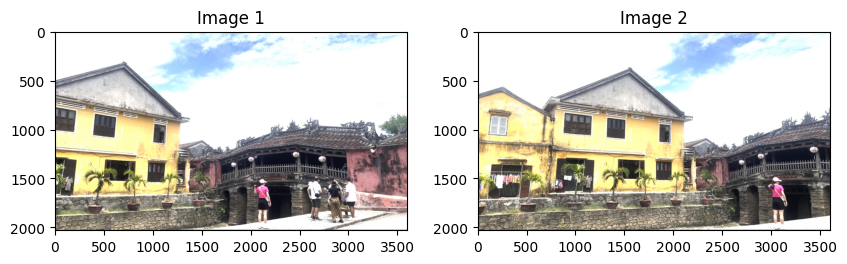

In [5]:
def show_img(img):
  plt.figure(figsize=(10, 10))
  plt.plot(221), plt.imshow(img), plt.title('Image')
  plt.xticks([]), plt.yticks([])
  plt.show()
def print_two_images(image1, image2, name1, name2):
  fig = plt.figure(figsize=(10, 7))
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.imshow(image1)
  ax1.set_title(name1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax2.imshow(image2)
  ax2.set_title(name2)
  plt.show()

print_two_images(img_list[0], img_list[1], 'Image 1', 'Image 2')

### 1. Detect and describe image

In [28]:
import cv2
import numpy as np


def detectAndDescribe(image, feature):
  # convert the image to gr
  image = np.array(image)
  kp= des = None
  if feature == "sift":
    sif = cv2.xfeatures2d.SIFT_create()
    (kp, des) = sif.detectAndCompute(image, None)

  elif feature == "orb":
    orb = cv2.ORB_create()
    kp = orb.detect(image,None)
    kp, des = orb.compute(image, kp)
  else:
    print("Feature not supported")
    return None

  kps = np.float64([k.pt for k in kp])
    # Draw keypoints on the image
  img_with_kps = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  return (kps, des, img_with_kps)


### 2. Match keypoints

In [7]:
def matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
  # compute the raw matches and initialize the list of actual
  # matches
  #matcher = cv2.BFMatcher()
  matcher = cv2.DescriptorMatcher_create("BruteForce")

  rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
  matches = []
  for m in rawMatches:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Grant ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
      matches.append((m[0].trainIdx, m[0].queryIdx))
      # computing a homography requires at least 4 matches
  if len(matches) > reprojThresh:
    # construct the two sets of points
    ptsA = np.float32([kpsA[i] for (_, i) in matches])
    ptsB = np.float32([kpsB[i] for (i, _) in matches])
    # compute the homography between the two sets of points
    (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
    # return the matches along with the homograpy matrix
    # and status of each matched point
    return (matches, H, status)
  return None

### 3. Draw matches

In [8]:
def drawMatches(imgA, kpsA, imgB, kpsB, matches, status):
  # initialize the output visualization image
  (hA, wA) = imgA.shape[:2]
  (hB, wB) = imgB.shape[:2]
  vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
  vis[0:hA, 0:wA] = imgA
  vis[0:hB, wA:] = imgB
  # loop over the matches
  for ((trainIdx, queryIdx), s) in zip(matches, status):
    # only process the match if the keypoint was successfully
    # matched
    if s == 1:
      # draw the match
      ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
      ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
      cv2.line(vis, ptA, ptB, (0, 255, 0), 1)  # return the visualization
  return vis

### 4. Stitch

In [26]:
def stitch(img_list, radio = 0.75, reprojThresh = 4.0, showMatches = False, feature='sift'):
  # Detect and describe keypoints in the two images
  kpsA, featureA, img_with_kpA = detectAndDescribe(img_list[0], feature)
  kpsB, featureB, img_with_kpB = detectAndDescribe(img_list[1], feature)
  # Match features between the two images
  M = matchKeypoints(kpsA, kpsB, featureA, featureB, radio, reprojThresh)
  # If the match is not None, unpack the matched keypoint
  # together with the homography
  if M is not None:
    (matches, H, status) = M
    # Use homography to warp the second image
    result = cv2.warpPerspective(img_list[0], H, (img_list[0].shape[1] + img_list[1].shape[1], img_list[0].shape[0]))
    result[0:img_list[1].shape[0], 0:img_list[1].shape[1]] = img_list[1]
    # If the showMatches flag is set, draw
    # the matched keypoints
    if showMatches:
      vis = drawMatches(img_list[0], kpsA, img_list[1], kpsB, matches, status)
      return (result, vis, img_with_kpA, img_with_kpB)
    return result
  return None


### 5.1. Run with "SIFT"

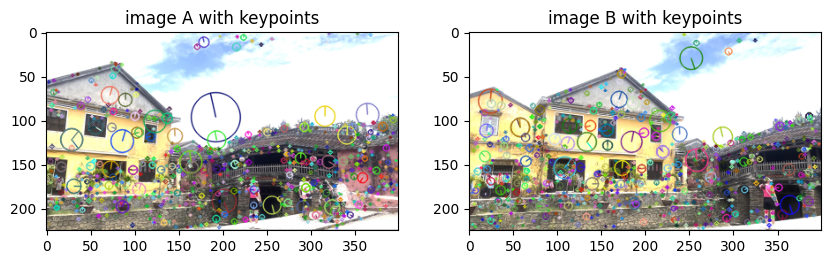

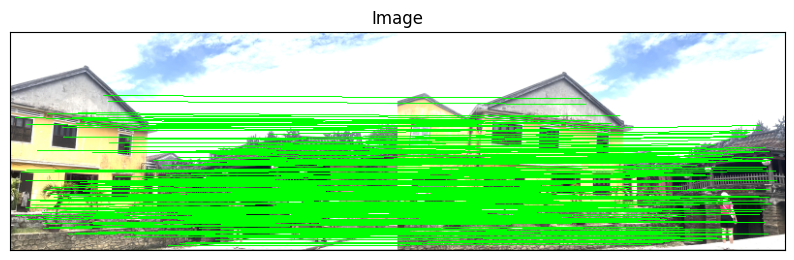

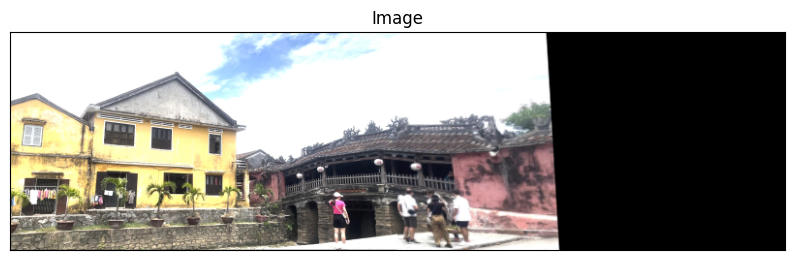

In [30]:
import imutils
import cv2

# Convert each PIL image to a NumPy array before resizing
img_array_list = [np.array(img) for img in img_list]

# Resize the images using imutils
resized_img_list = [imutils.resize(img, width=400) for img in img_array_list]
(result, vis, a, b) = stitch(resized_img_list,radio=0.75,reprojThresh = 4, showMatches=True, feature='sift')
print_two_images(a, b,'image A with keypoints', 'image B with keypoints')
show_img(vis)
show_img(result)

### 5.2. Run with "ORB"

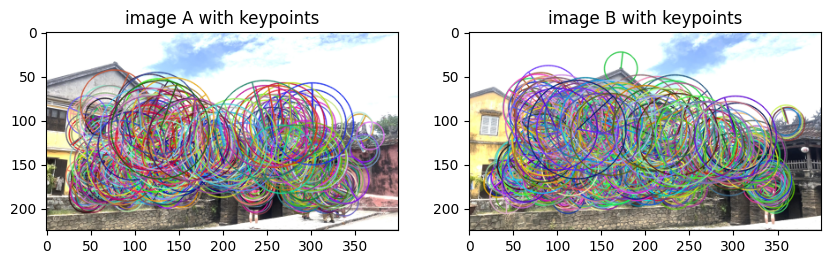

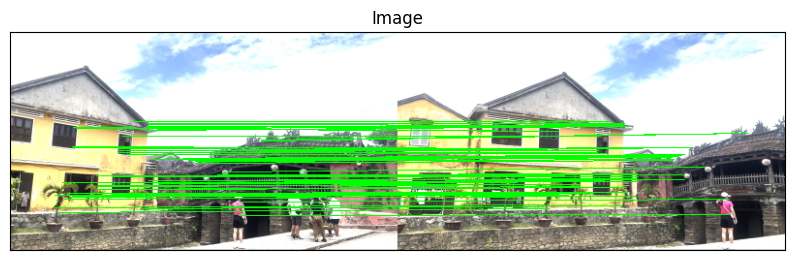

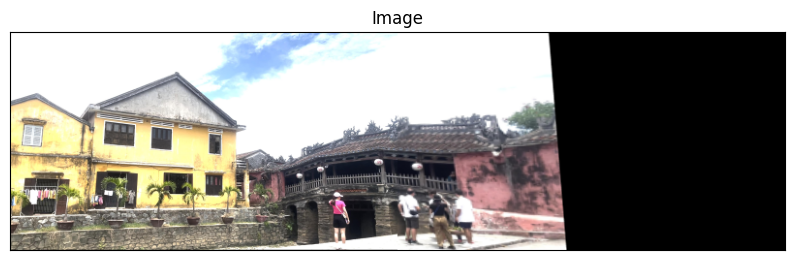

In [31]:
(result, vis, a, b) = stitch(resized_img_list,radio=0.75,reprojThresh = 4, showMatches=True, feature='orb')
print_two_images(a, b,'image A with keypoints', 'image B with keypoints')
show_img(vis)
show_img(result)